[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/image/image-retrieval-ebook/vision-transformers/vit.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/image/image-retrieval-ebook/vision-transformers/vit.ipynb)

# Vision Transformers (ViT) Walkthrough

In [1]:
!pip install datasets transformers torch

Let's start by downloading the CIFAR-10 dataset from HuggingFace. We will first download the training dataset by setting ```split = 'train'```, and the testing dataset after by setting ```split = 'test'```.

In [2]:
import json
from datasets import Dataset, DatasetDict
from collections import Counter
from PIL import Image
import os
from sklearn.model_selection import train_test_split
img_dir = '/kaggle/input/forestfirevalid/cropped/cropped'
json_file = '/kaggle/input/forestfirevalid/cropped/cropped/labels.txt'
# Step 1: Load the JSON data
f = open(json_file, "r")
labels = f.read()
labels = labels[1:-1]
labels = labels.split(",")
print(type(labels))
'''
# # Helper function to get the most common label for each image
# def get_most_common_label(annotations, image_id):
#     possible_labels = []
#     for annotation in annotations:
#         if annotation['image_id'] == image_id:
#             possible_labels.append(annotation['category_id'])
    
#     if len(possible_labels) == 0:
#         return 2
#     else:
#         return Counter(possible_labels).most_common(1)[0][0]
'''


# List comprehension to get all file names with .jpg extension in the specified directory.
jpg_files = [file for file in os.listdir(img_dir) if file.endswith('.jpg')]
sorted_jpg_files = sorted(jpg_files, key=lambda x: int(x.split('.')[0]))
# # Step 2: Process annotations
image_data = {}
for i, image in enumerate(sorted_jpg_files):
    most_common_label = labels[i]
    image_data[i] = {
        'image_file_path': os.path.join(img_dir, image),
        'label': int(most_common_label)
    }

print(type(image_data))

items = list(image_data.items())
train_items, test_items = train_test_split(items, test_size=0.2, random_state=42)

# Convert lists back to dictionaries
train_dict = dict(train_items)
test_dict = dict(test_items)

# Extract keys from the train and test dictionaries
train_keys = list(train_dict.keys())
test_keys = list(test_dict.keys())

# print("Train keys:", train_keys)
# print("Test keys:", test_keys)

'''
# train_size = int(0.8 * len(labels))
# test_size = int(0.2 * len(labels))



# # # Step 3: Create Hugging Face `Dataset` objects
# def create_dataset(image_data):
#     dataset = {
#         'image_file_path': [],
#         'image': [],
#         'labels': []
#     }
#     for i in range le(image_data):
#         data = image_data[i]
#         dataset['image_file_path'].append(data['image_file_path'])
#         # Assuming you want to load the images as PIL images here
#         with Image.open(data['image_file_path']) as img:
#             dataset['image'].append(img)
#         dataset['labels'].append(data['label'])
#     return Dataset.from_dict(dataset)
'''

def create_dataset(image_data):
    dataset = {
        'image_file_path': [],
        'image': [],
        'labels': []
    }
    for image_id, value in image_data.items():
        data = value
        dataset['image_file_path'].append(data['image_file_path'])
        # Assuming you want to load the images as PIL images here
        with Image.open(data['image_file_path']) as img:
            dataset['image'].append(img)
        dataset['labels'].append(data['label'])
    return Dataset.from_dict(dataset)

# # Step 4: Create datasets for each split
train_dataset = create_dataset(train_dict)
test_dataset = create_dataset(test_dict)

# # Step 5: Create the `DatasetDict`
dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

# # Print the structure (optional)
print(dataset_dict)

<class 'list'>
<class 'dict'>
DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 2619
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 655
    })
})


In [3]:
# check how many labels/number of classes
num_classes = 3
labels = ['Smoke', 'Fire', 'Neither']
num_classes, labels

(3, ['Smoke', 'Fire', 'Neither'])

*Training*: 50,000 images divided into 10 classes

*Test*: 10,000 images divided into 10 classes

In [4]:
dataset_dict["train"][0]

{'image_file_path': '/kaggle/input/forestfirevalid/cropped/cropped/2314.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=38x131>,
 'labels': 0}

Those are PIL images with $3$ color channels, and $32x32$ pixels resolution. Let's have a look at the first picture in the dataset.

In [5]:
dataset_dict["train"][0]['labels'], labels[(dataset_dict["train"][0]['labels'])]

(0, 'Smoke')

### Loading ViT Feature Extractor

We use `google/vit-base-patch16-224-in21k` model from the Hugging Face Hub.

The model is named as so as it refers to base-sized architecture with patch resolution of 16x16 and fine-tuning resolution of 224x224.  

In [6]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

2024-04-26 07:27:48.634844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 07:27:48.634955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 07:27:48.756812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


You can see the feature extractor configuration by printing it

In [7]:
feature_extractor

ViTFeatureExtractor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

If we consider the first image, i.e., the airplane shown above, we can see the resulting tensor after passing the image through the feature extractor. 

In [8]:
dataset_train = dataset_dict["train"]
dataset_test = dataset_dict["test"]
print(dataset_train)

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 2619
})


In [9]:
example = feature_extractor(
    dataset_train[0]['image'],
    return_tensors='pt'
)
example

{'pixel_values': tensor([[[[-0.0510, -0.0510, -0.0510,  ..., -0.1059, -0.1059, -0.1059],
          [-0.0510, -0.0510, -0.0510,  ..., -0.0980, -0.0980, -0.0980],
          [-0.0431, -0.0431, -0.0431,  ..., -0.0902, -0.0902, -0.0902],
          ...,
          [-0.0510, -0.0510, -0.0510,  ..., -0.0510, -0.0510, -0.0510],
          [-0.0588, -0.0588, -0.0588,  ..., -0.0353, -0.0353, -0.0353],
          [-0.0588, -0.0588, -0.0588,  ..., -0.0275, -0.0275, -0.0275]],

         [[-0.0431, -0.0431, -0.0431,  ..., -0.1059, -0.1059, -0.1059],
          [-0.0431, -0.0431, -0.0431,  ..., -0.0980, -0.0980, -0.0980],
          [-0.0353, -0.0353, -0.0353,  ..., -0.0902, -0.0902, -0.0902],
          ...,
          [-0.0745, -0.0745, -0.0745,  ..., -0.1059, -0.1059, -0.1059],
          [-0.0824, -0.0824, -0.0824,  ..., -0.0902, -0.0902, -0.0902],
          [-0.0824, -0.0824, -0.0824,  ..., -0.0824, -0.0824, -0.0824]],

         [[-0.1843, -0.1843, -0.1843,  ..., -0.2000, -0.2000, -0.2000],
          [-0

In [10]:
example['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [11]:

import torch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
def preprocess(batch):
    inputs = feature_extractor(
        batch['image'],
        return_tensors='pt'
    )

    inputs['label'] = batch['labels']
    return inputs

We can apply this to both the training and testing dataset.

In [13]:
prepared_train = dataset_train.with_transform(preprocess)
prepared_test = dataset_test.with_transform(preprocess)

Now, whenever you get an example from the dataset, the transform will be applied in real time (on both samples and slices).

### Model Fine-Tuning

In this section, we are going to build the Trainer, which is a feature-complete training and eval loop for PyTorch, optimized for HuggingFace 🤗 Transformers.

We need to define all of the arguments that it will include:
* training and testing dataset
* feature extractor
* model
* collate function
* evaluation metric
* ... other training arguments.

The collate function is useful when dealing with lots of data. Batches are lists of dictionaries, so collate will help us create batch tensors.

In [14]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

Let's now define the evaluation metric we are going to use to compare prediction with actual labels. We will use the *accuracy evaluation metric*. 

Accuracy is defined as the proportion of correct predictions (True Positive ($TP$) and True Negative ($TN$)) among the total number of cases processed ($TP$, $TN$, False Positive ($FP$), and False Negative ($FN$)). 

$$Accuracy = \frac{(TP + TN)}{(TP + TN + FP + FN)}$$    

Below, we are using accuracy within the ```compute_metrics``` function.

In [15]:
import numpy as np
from datasets import load_metric

# accuracy metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/tmp/ipykernel_34/270454614.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


The last thing consists of defining ```TrainingArguments```.

Most of these are pretty self-explanatory, but one that is quite important here is ```remove_unused_columns=False```. This one will drop any features not used by the model's call function. By default it's True because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

We have chosen a batch size equal to 16, 100 evaluation steps, and a learning rate of $2e^{-4}$.

In [16]:
from transformers import TrainingArguments
training_args = TrainingArguments(
  output_dir="./ForestFire",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

We can now load the pre-trained model. We'll add ```num_labels``` on init so the model creates a classification head with the right number of units.

In [17]:
from transformers import ViTForImageClassification

labels = ['Smoke', 'Fire', 'Neutral']

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

We can see the characteristics of our model.

Now, all instances can be passed to ```Trainer```.

In [19]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


We can save our trained model.

In [20]:
# train_results = trainer.train()
# # save tokenizer with the model
# trainer.save_model()
# trainer.log_metrics("train", train_results.metrics)
# trainer.save_metrics("train", train_results.metrics)
# # save the trainer state
# trainer.save_state()

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.241300,0.108372,0.970992
200,0.024900,0.158344,0.964885
300,0.083000,0.070557,0.978626
400,0.064200,0.063544,0.980153
500,0.007300,0.088897,0.972519
600,0.011200,0.062107,0.984733


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 756060107GF
  train_loss               =      0.0879
  train_runtime            =  0:05:28.78
  train_samples_per_second =      31.863
  train_steps_per_second   =       1.995


#### Model Evaluation

We can now evaluate our model using the accuracy metric defined above...

In [21]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9847
  eval_loss               =     0.0621
  eval_runtime            = 0:00:08.87
  eval_samples_per_second =     73.824
  eval_steps_per_second   =      9.242


Model accuracy is pretty good. Let's have a look to an example. We can pick the first image in our testing dataset and see if the predicted label is correct.

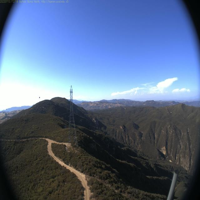

In [22]:
# show the first image of the testing dataset
image = dataset_test[0]["image"].resize((200,200))
image

The image is not very clear, even when resized. Let's extract the actual label.

In [23]:
# extract the actual label of the first image of the testing dataset
actual_label = dataset_test[0]['labels']

labels = ["Smoke","Fire", "neither"]
actual_label, labels[actual_label]


(2, 'neither')

It looks like the image represents a cat. Let's now see what our model has predicted. Given we saved it on the HuggingFace Hub, we first need to import it. We can use ViTForImageClassification and ViTFeatureExtractor to import the model and extract its features. We would need the predicted pixel values "pt".

In [24]:
from transformers import ViTForImageClassification, ViTFeatureExtractor

# import our fine-tuned model
model_name_or_path = '/kaggle/working/ForestFire'
model_finetuned = ViTForImageClassification.from_pretrained(model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [25]:
inputs = feature_extractor_finetuned(image, return_tensors="pt")

with torch.no_grad():
    logits = model_finetuned(**inputs).logits

We can now see what is our predicted label. Do extract it, we can use the argmax function.

In [26]:
predicted_label = logits.argmax(-1).item()
labels = labels = ["Smoke","Fire", "neither"]
labels[predicted_label]

'neither'

In [27]:
# output_name = 'my_archive'

# # Specify the directory you want to zip
# directory_to_zip = '/kaggle/working/ForestFire'

# # Create a zip archive of the specified directory
# shutil.make_archive(output_name, 'zip', directory_to_zip)

In [38]:
import json
import cv2
json_file = '/kaggle/input/forestfirevalid/res.json'
with open(json_file, 'r') as f:
    results = json.load(f)

annots_file = '/kaggle/input/forestfirevalid/_annotations.coco.json'
with open(annots_file, 'r') as f:
    annotations_data = json.load(f)
    
files = {}

for images in annotations_data['images']:
    files[images['id']] = images['file_name']
print("done")
updated_results =[]    
count = 0
num2s=0
for result in results:
    if count % 100 == 0:
        print(count)
    count+=1
    image_id = result['image_id']
    file_name = files[image_id]
    image_path = f'/kaggle/input/forestfirevalid/valid/valid/{file_name}'
    image = cv2.imread(image_path)
    bbox = result['bbox']
    
    if image is not None:
        x = int(round(bbox[0]))
        y = int(round(bbox[1]))
        width = int(round(bbox[2]))
        height = int(round(bbox[3]))
        crop_image = image[y:y+height, x:x+width]
        try:
            inputs = feature_extractor_finetuned(crop_image, return_tensors="pt")
            with torch.no_grad():
                logits = model_finetuned(**inputs).logits
            predicted_label = logits.argmax(-1).item()
            if result['category_id'] == predicted_label:
                updated_results.append(result)
            
        except:
            crop_image
            image
        

done
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


In [41]:
# %pip install pycocotools
from pycocotools.coco import COCO 
from pycocotools.cocoeval import COCOeval
import copy 

print(len(updated_results))

json_file = '/kaggle/input/forestfirevalid/res.json'
with open(json_file, 'r') as f:
    results = json.load(f)
result_copy = copy.deepcopy(results)

for result in results:
    if result not in updated_results:
        result_copy.remove(result)

print(len(result_copy))  

with open('/kaggle/working/_annotations2.coco.json', 'w') as file:
    json.dump(result_copy, file)

# print(len(updated_results))
cocoGt = COCO('/kaggle/input/forestfirevalid/_annotations.coco.json') 
cocoDt = cocoGt.loadRes('/kaggle/working/_annotations2.coco.json')  

coco_eval = COCOeval(cocoGt, cocoDt, 'bbox')


imgIds = sorted(cocoGt.getImgIds())
coco_eval.params.imgIds = imgIds 

coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()
# 
# Writing the list to a JSON file


Note: you may need to restart the kernel to use updated packages.
1044
1044
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.142
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.185
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 1

## References

[Article](https://pinecone.io/learn/vision-transformers/)

[1] Dosovitskiy et al., [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929), 2021, CV.

[2] Vaswani et al., [Attention Is All You Need](https://arxiv.org/abs/1706.03762), 2017.

[3] Saeed M., [A Gentle Introduction to Positional Encoding in Transformer Models, Part 1](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/), 2022, Attention, Machine Learning Mastery.